# Solving a Krichhoff plate blending problem with Morley element
Problem:
$$ \Delta^2 u = f \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
note:
$$\Delta^{2} \equiv \nabla^{4}=\frac{\partial^{4}}{\partial x^{4}}+2 \frac{\partial^{4}}{\partial x^{2} \partial y^{2}}+\frac{\partial^{4}}{\partial y^{4}}$$
In this case, we consider $\Omega=(0,1) \times(0,1)$ and try
$$ 
f(x, y)=24\left[\left(x^{2}-x+1\right)^{2}+\left(y^{2}-y+1\right)^{2}+12\left(x^{2}-x\right)\left(y^{2}-y\right)\right]-40
$$
from 
$$
u(x, y)=x^{2}(1-x)^{2} y^{2}(1-y)^{2}
$$
We can write the problem as:
$$ \int_\Omega \boldsymbol{K}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V $$

In [1]:
from skfem.models.poisson import unit_load
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import dd, ddot
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Assembling $K$ $f$ and storing boundary condition in `D`
mesh refined with m.refine(5)

In [15]:
m = MeshTri()
# m = MeshTri.init_symmetric()
m.refine(5)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v


dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                    dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

K = asm(bilinf, ib)
f = asm(mybih, ib)

## Solving $Ku = f$ using `pcg`

In [16]:
%%time
u = solve(*condense(K, f, D=D), solver=solver_iter_pcg()) 

Wall time: 31.9 ms


In [17]:
np.sqrt(4225)

65.0

## Plotting results $\tilde{u}_{h}$

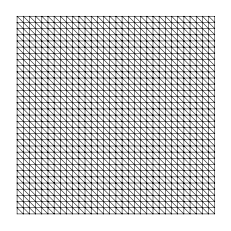

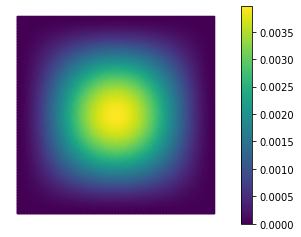

In [18]:
ax = draw(m)
# plot(ib, u, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)
plot(ib, u, shading='gouraud', colorbar=True, Nrefs=2)
plt.show()

## Plotting original $u$

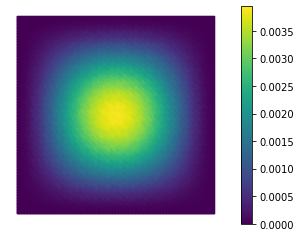

In [19]:
def orig(x, y):
    return (x * y * (1 - x) * (1 - y))**2


x = ib.doflocs[0]
y = ib.doflocs[1]
u_ori = orig(x, y)

plot(ib, u_ori, shading='gouraud', colorbar=True, Nrefs=2)
plt.show()

## Caculating error

In [20]:
bias = u-u_ori
print('inf-norm: ', max(u-u_ori))
print('Mean L^2-Norm: ', np.linalg.norm(bias, ord=2)/len(bias))

inf-norm:  0.010414381990966648
Mean L^2-Norm:  7.512704333900427e-05


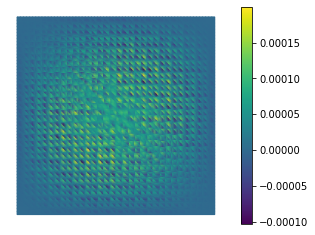

In [21]:
plot(ib, u-u_ori, shading='gouraud', colorbar=True)
plt.show()

## Trying different orders

2^-1 case
Mean L^2-Norm:  0.0008158118139807287
2^-2 case
Mean L^2-Norm:  0.0005049547565439847
2^-3 case
Mean L^2-Norm:  0.00027685894381405246
2^-4 case
Mean L^2-Norm:  0.0001460035901343649
2^-5 case
Mean L^2-Norm:  7.512704333900427e-05
2^-6 case
Mean L^2-Norm:  3.812970507283017e-05
2^-7 case
Mean L^2-Norm:  1.9211147865018284e-05


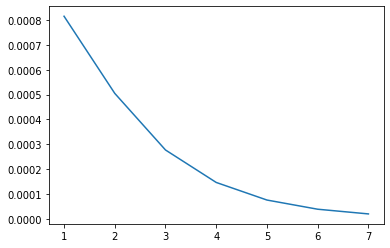

In [8]:
norm_list = []
maxorder = 8

for order in range(1, maxorder):
    m = MeshTri()
    # m = MeshTri.init_symmetric()
    m.refine(order)

    e = ElementTriMorley()
    ib = InteriorBasis(m, e)


    @BilinearForm
    def bilinf(u, v, w):
        return ddot(dd(u), dd(v))


    @LinearForm
    def mybih(v, w):
        x, y = w.x
        return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                      (y - 1) * x * y) - 40) * v


    dofs = ib.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

    K = asm(bilinf, ib)
    f = asm(mybih, ib)

    u = solve(*condense(K, f, D=D), solver=solver_iter_pcg())
    
    x = ib.doflocs[0]
    y = ib.doflocs[1]
    u_ori = orig(x, y)

    bias = u - u_ori
    # l2norm = np.linalg.norm(bias, ord=2) / (2**order)**0.5
    l2norm = np.linalg.norm(bias, ord=2)/len(bias)
    print('2^-'+str(order)+' case')
    # print('inf-norm: ', max(u - u_ori))
    print('Mean L^2-Norm: ', l2norm)
    norm_list.append(l2norm)

plt.plot(range(1,maxorder), norm_list)
plt.show()